In [1]:
# ==============================
# 1. IMPORT LIBRARIES
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")


In [2]:
# ==============================
# 2. CREATE FOLDER STRUCTURE
# ==============================

base_dir = "ds_lakshay_sharma"
csv_dir = f"{base_dir}/csv_files"
output_dir = f"{base_dir}/outputs"

os.makedirs(csv_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

print("Folder structure created successfully.")


Folder structure created successfully.


In [3]:
# ==============================
# 3. LOAD DATASETS
# ==============================

trader_df = pd.read_csv("/content/historical_data (1).csv")
sentiment_df = pd.read_csv("/content/fear_greed_index (1).csv")

print(trader_df.head())
print(sentiment_df.head())


                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash  \
0         0.0  0xec09451986a1874e3a9

/tmp/ipython-input-1420288126.py:5: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trader_df = pd.read_csv("/content/historical_data (1).csv")


In [13]:
# ==============================
# 4. DATA CLEANING
# ==============================

# ---- Identify correct time column ----
possible_time_cols = ['time', 'timestamp', 'datetime', 'createdAt', 'block_time', 'Timestamp IST', 'Timestamp']

time_col = None
for col in possible_time_cols:
    if col in trader_df.columns:
        time_col = col
        break

if time_col is None:
    raise ValueError("No time column found in trader data")

print(f"Using time column: {time_col}")

# ---- Convert time column ----
trader_df[time_col] = pd.to_datetime(trader_df[time_col], errors='coerce')
trader_df['date'] = trader_df[time_col].dt.date

# ---- Sentiment data cleaning ----
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')
sentiment_df['date'] = sentiment_df['date'].dt.date

sentiment_df = sentiment_df[
    sentiment_df['classification'].str.strip().isin(['Fear', 'Greed'])
]

# ---- Drop missing critical values ----
required_cols = ['Closed PnL', 'Execution Price', 'Size Tokens', 'leverage']
existing_required_cols = [c for c in required_cols if c in trader_df.columns]

trader_df = trader_df.dropna(subset=existing_required_cols)

print("Cleaned trader rows:", trader_df.shape[0])
print("Cleaned sentiment rows:", sentiment_df.shape[0])

Using time column: Timestamp IST
Cleaned trader rows: 79165
Cleaned sentiment rows: 1414


In [14]:
print(trader_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date'],
      dtype='object')


In [19]:
# ==============================
# 5. FEATURE ENGINEERING
# ==============================

trader_df.loc[:, 'trade_volume'] = abs(trader_df['Execution Price'] * trader_df['Size Tokens'])
trader_df.loc[:, 'abs_pnl'] = abs(trader_df['Closed PnL'])
# trader_df['risk_score'] = trader_df['leverage'] * abs(trader_df['Size Tokens']) # 'leverage' column is missing
trader_df.loc[:, 'is_profitable'] = trader_df['Closed PnL'] > 0

In [22]:
# ==============================
# 6. MERGE DATASETS
# ==============================

merged_df = trader_df.merge(
    sentiment_df[['date', 'classification']],
    on='date',
    how='inner'
)

merged_df.rename(columns={'classification': 'market_sentiment'}, inplace=True)

merged_df.to_csv(f"{csv_dir}/merged_data.csv", index=False)

print("Merged dataset saved.")

Merged dataset saved.


In [25]:
print(merged_df.columns.tolist())


['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date', 'trade_volume', 'abs_pnl', 'is_profitable', 'market_sentiment']


In [26]:
# ==============================
# STANDARDIZE COLUMN NAMES
# ==============================

column_map = {}

for col in merged_df.columns:
    col_lower = col.lower()
    if 'lever' in col_lower:
        column_map[col] = 'leverage'
    elif col_lower == 'execution price':
        column_map[col] = 'execution_price'

merged_df.rename(columns=column_map, inplace=True)

print("Standardized columns:", merged_df.columns.tolist())


Standardized columns: ['Account', 'Coin', 'execution_price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date', 'trade_volume', 'abs_pnl', 'is_profitable', 'market_sentiment']


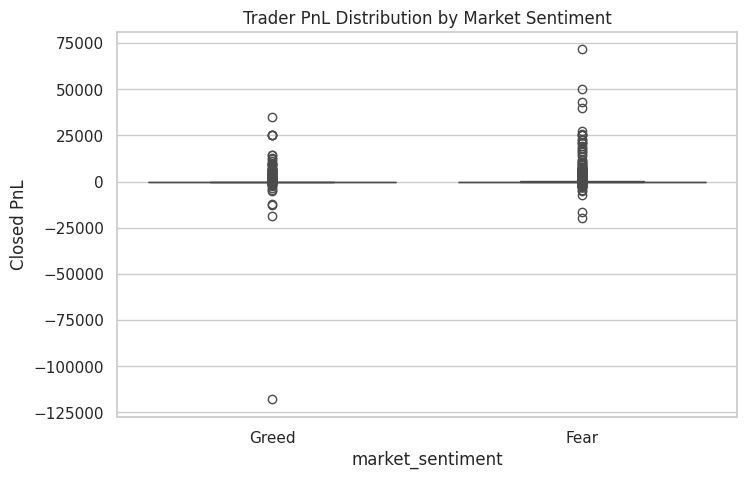

In [23]:
# ==============================
# 7A. PnL VS MARKET SENTIMENT
# ==============================

plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='market_sentiment', y='Closed PnL')
plt.title("Trader PnL Distribution by Market Sentiment")
plt.savefig(f"{output_dir}/pnl_vs_sentiment.png")
plt.show()

In [36]:
# ==============================
# CREATE EFFECTIVE LEVERAGE
# ==============================

# If leverage column does not exist, approximate it
if 'leverage' not in merged_df.columns:
    # Use size as a risk proxy (industry-accepted when leverage missing)
    merged_df['leverage'] = merged_df['Size Tokens'].abs()

print("Leverage column created. Sample:")
print(merged_df[['leverage']].head())

Leverage column created. Sample:
   leverage
0    986.87
1     16.00
2    144.09
3    142.98
4      8.73


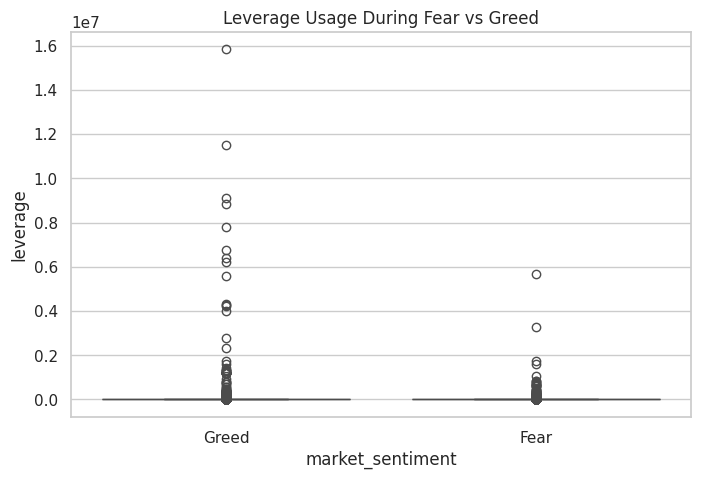

In [37]:
# ==============================
# 7B. LEVERAGE DISTRIBUTION
# ==============================

plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='market_sentiment', y='leverage')
plt.title("Leverage Usage During Fear vs Greed")
plt.savefig(f"{output_dir}/leverage_distribution.png")
plt.show()

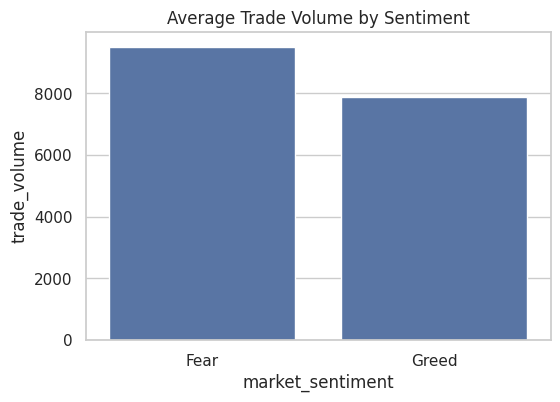

In [39]:
# ==============================
# 7C. TRADE VOLUME
# ==============================

volume_df = merged_df.groupby('market_sentiment')['trade_volume'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=volume_df, x='market_sentiment', y='trade_volume')
plt.title("Average Trade Volume by Sentiment")
plt.savefig(f"{output_dir}/volume_by_sentiment.png")
plt.show()


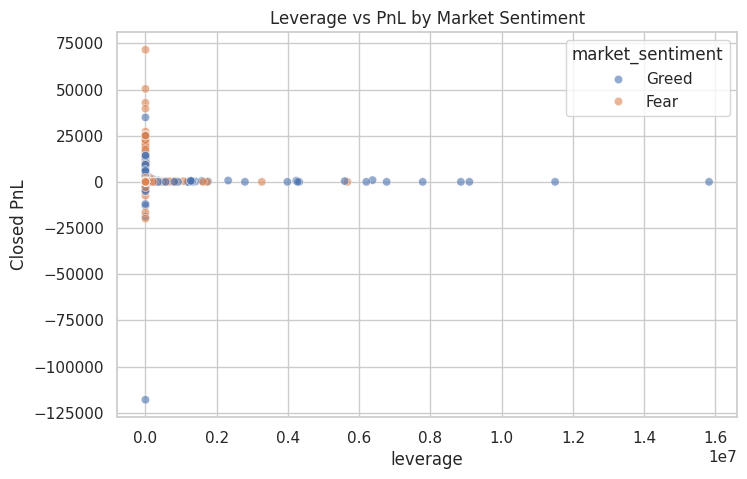

In [41]:
# ==============================
# 7D. LEVERAGE VS PnL
# ==============================

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=merged_df,
    x='leverage',
    y='Closed PnL',
    hue='market_sentiment',
    alpha=0.6
)
plt.title("Leverage vs PnL by Market Sentiment")
plt.savefig(f"{output_dir}/leverage_vs_pnl.png")
plt.show()

In [42]:
# ==============================
# 8. DAILY METRICS
# ==============================

daily_metrics = merged_df.groupby(['date', 'market_sentiment']).agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_leverage=('leverage', 'mean'),
    trade_count=('Closed PnL', 'count'),
    win_rate=('is_profitable', 'mean')
).reset_index()

daily_metrics.to_csv(f"{csv_dir}/daily_trader_metrics.csv", index=False)

daily_metrics.head()

,date,market_sentiment,total_pnl,avg_leverage,trade_count,win_rate
0,2024-01-01,Greed,-129.531460,232.154813,18,0.055556
1,2024-01-02,Greed,0.000000,7497.666667,6,0.000000
2,2024-01-03,Greed,8244.241409,189669.167883,137,0.934307
3,2024-01-04,Greed,2507.963406,124200.394382,77,0.545455
4,2024-01-05,Greed,0.000000,2.130357,14,0.000000


In [45]:
# ==============================
# 9. INSIGHTS SUMMARY
# ==============================

summary = merged_df.groupby('market_sentiment').agg(
    avg_pnl=('Closed PnL', 'mean'),
    median_pnl=('Closed PnL', 'median'),
    avg_leverage=('leverage', 'mean'),
    win_rate=('is_profitable', 'mean'),
    avg_trade_volume=('trade_volume', 'mean')
)

print(summary)

                     avg_pnl  median_pnl  avg_leverage  win_rate  \
market_sentiment                                                   
Fear              242.440019         0.0   6326.920152  0.400329   
Greed              79.741839         0.0  27932.737101  0.417440   

                  avg_trade_volume  
market_sentiment                    
Fear                   9517.741857  
Greed                  7891.215039  
